# Plot slope failure detections and meteo data

In [1]:
import numpy as np
import pandas as pd
import obspy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from datetime import datetime, timedelta
import time
from scipy import signal
from ComputeAttributes_CH_V1 import *
from DF_detections import *
from ILL_functions import *

In [2]:
# set plotting default parameters
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.figsize'] = (6.4, 4.8) # if wider plot, only change first value.
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana']
#plt.rcParams['ytick.major.pad']= 2

cmcolors = plt.get_cmap('magma').colors
cmap = plt.get_cmap('magma')
# Specify colors
colors = [cmcolors[20],cmcolors[120],cmcolors[180],cmcolors[200]]

In [5]:
# read df
year = 2021
file_ending = 'test_v4_bigsf_clf2'
plot_ending = 'v4_bigsf_clf2'
path_to_raw_data = '/data/wsd03/data_manuela/Illgraben/miniseed/'

class_res, dttimes, all_class, tslops, dslops = read_features(year, file_ending)
df_group_d, df_group, ns_dat, ns_group_d, ns_group = read_meteo(class_res, year)

ts,te = DF_detections(year)

## start masking and plotting

In [7]:
# Get start and endtime
tstart = obspy.UTCDateTime(df_group_d.index[0]) #obspy.UTCDateTime(f'{year}-06-20')
tend = obspy.UTCDateTime(df_group_d.index[-1]) #tstart + timedelta(days=7*12)

gr_mask = (df_group_d.index > tstart.date) & (df_group_d.index <= tend.date) # daily
ns_mask = (ns_dat.index > tstart.datetime) & (ns_dat.index<= tend.datetime) # hourly
ns_gr_mask = (ns_group_d.index > tstart) & (ns_group_d.index<= tend) #daily
df_gr_mask = df_group_d[gr_mask] # daily
df_ns_mask = ns_dat[ns_mask] # hourly -> with ns but only summer season
df_ns_gr_mask = ns_group_d[ns_gr_mask] # daily

(98.99999999999997, 0.0)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


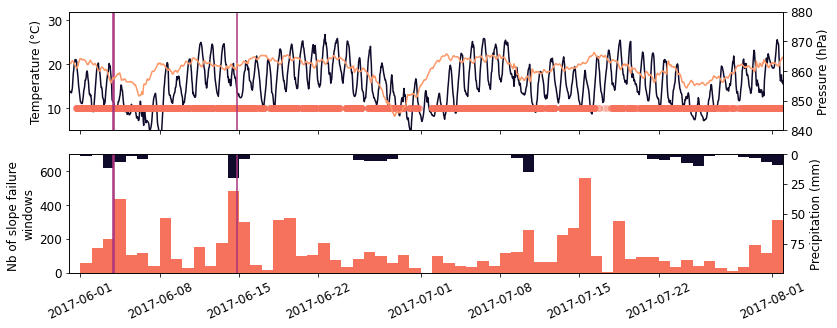

In [8]:
 fig, (ax1,ax0) = plt.subplots(2,1,figsize=(6.4*2, 4.8), sharex=True)
# Plot air temperature over time
ax1.plot_date(df_ns_mask.index, df_ns_mask['261'], '-', color=colors[0], label='Air temperature')
# Plot slope failures over time
ax1.plot(dttimes, [x*10 for x in all_class], 'o', alpha=0.3, color=colors[2], label='Slope failures')

ax1.set_ylim(5,32)

ax2 = ax1.twinx()
ax3 = ax0.twinx()
# Plot precipitation over time
ax2.plot_date(df_ns_mask.index, df_ns_mask['306'], '-',color=colors[3], label='Atmospheric pressure')

ax1.set_ylabel('Temperature (°C)')
ax2.set_ylabel('Pressure (hPa)')
ax2.set_ylim(840,880)
#ax1.set_xlim(datetime.strptime('201906191945', "%Y%m%d%H%M"), datetime.strptime('201909191945', "%Y%m%d%H%M"))
ax1.set_xlim(tstart.datetime,tend.datetime)

# Plot debris-flow events as vertical lines
for ts_i in ts:
    ax1.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color=colors[1])
    ax3.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color=colors[1])

# Plot slope failures per day
ax0.bar(df_gr_mask.index, df_gr_mask['classes'], width=1, color=colors[2],align='edge', label='Nb of slope failures per day')
ax0.xaxis_date()
ax0.set_ylabel('Nb of slope failure \nwindows')
ax0.tick_params(axis='x', rotation=25)
ymax = np.max(df_gr_mask['classes'])+0.25*np.max(df_gr_mask['classes'])
ax0.set_ylim(0,ymax)

# Plot precipitation per daz
ax3.bar(df_ns_gr_mask.index, df_ns_gr_mask['267'], width=1 ,color=colors[0], align='edge', label='Precipitation per day')
ax3.xaxis_date()
ax3.set_ylabel('Precipitation (mm)')
ax3.set_ylim(0,np.max(df_ns_gr_mask['267'])/(ymax-np.max(df_gr_mask['classes']))*ymax) # adjust the second yscale to 100%
ax3.set_ylim(ax3.get_ylim()[::-1])

#plt.savefig(f'../plot/{year}/0_eval_{year}_{plot_ending}.png',bbox_inches='tight', dpi=300)


In [9]:
# Get start and endtime
#tstart = obspy.UTCDateTime(f'{year}-06-21')
tend = tstart + timedelta(days=7)

gr_mask = (df_group_d.index > tstart.date) & (df_group_d.index <= tend.date) # daily
ns_mask = (ns_dat.index > tstart.datetime) & (ns_dat.index<= tend.datetime) # hourly
ns_gr_mask = (ns_group_d.index > tstart) & (ns_group_d.index<= tend) #daily
df_gr_mask = df_group_d[gr_mask] # daily
df_ns_mask = ns_dat[ns_mask] # hourly
df_ns_gr_mask = ns_group_d[ns_gr_mask] # daily

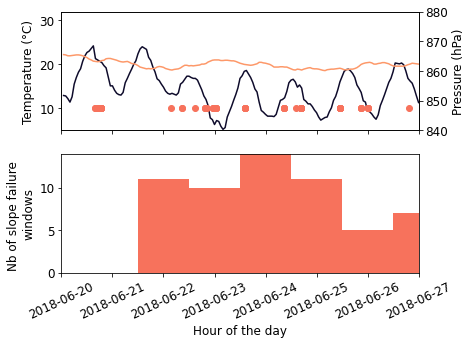

In [11]:
# Zoom in
fig, (ax1,ax0) = plt.subplots(2,1,figsize=(6.4, 4.8), sharex=True)

ax1.plot_date(df_ns_mask.index, df_ns_mask['261'], '-', color=colors[0], label='Air temperature at surface')
ax1.plot(dttimes, [x*10 for x in all_class], 'o', alpha=0.3, color=colors[2], label='Slope failures')

# Plot debris-flow events as vertical lines
for ts_i in ts:
    ax1.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color=colors[1])
ax1.set_ylim(5,32)

ax2 = ax1.twinx()
ax2.plot_date(df_ns_mask.index, df_ns_mask['306'], '-',color=colors[3], label='Atmospheric pressure')
ax1.set_ylabel('Temperature (°C)')
ax2.set_ylabel('Pressure (hPa)')

# Limit to zoom
#ax1.set_xlim(datetime.strptime('2019060000', "%Y%m%d%H%M"), datetime.strptime('201906230000', "%Y%m%d%H%M"))
ax1.set_xlim(tstart.datetime,tend.datetime)
ax1.tick_params(axis='x', rotation=25)
#ax1.legend(loc='upper right')
#ax2.legend(loc='lower right')
ax2.set_ylim(840,880)

ax0.bar(df_gr_mask.index, df_gr_mask['classes'], width=1, color=colors[2])
ax0.set_xlabel('Hour of the day')
ax0.set_ylabel('Nb of slope failure \nwindows')
ax0.set_ylim(0,np.max(df_gr_mask['classes']))
ax0.tick_params(axis='x', rotation=25)

#plt.legend(bbox_to_anchor = (1.04,1), loc="upper left")

#plt.savefig(f'../plot/{year}/eval_{year}_zoom_{plot_ending}.png', bbox_inches='tight', dpi=300)

### Higher resolution during debris flow events

In [14]:
# Define which debris-flow event you want to plot
evnb = 3 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Get start and endtime
tstart = obspy.UTCDateTime(ts[evnb])
tend = obspy.UTCDateTime(te[evnb])
tds = tstart.datetime
tde = tend.datetime

# Mask data untl 3 hours before and 5 hours after
dec_mask = (df_group.index > tds - timedelta(seconds=3*3600)) & (df_group.index <= tde + timedelta(seconds=5*3600))
ns_mask = (ns_group.index > tds - timedelta(seconds=3*3600)) & (ns_group.index<= tde + timedelta(seconds=5*3600))
decs = df_group[dec_mask]
nss = ns_group[ns_mask]

# Get raw data
st = obspy.read(path_to_raw_data + f"{year}/XP/ILL?8/EHZ.D/*.ILL?8.*{tstart.julday}")
#st1 = st.select(station=["ILL16", "ILL17", "ILL18"])

# Append raw data if endtime is on the next day 
if tend > st[0].stats.endtime:
    st1 = obspy.read(path_to_raw_data + f"{year}/XP/ILL?8/EHZ.D/*.ILL?8.*{tstart.julday + 1}")
    for tr in st1:
        st += tr
    
# Som preprocessing
st.merge(fill_value='interpolate')
st.trim(tstart-3*3600, tend+5*3600)
st.merge(method='interpolate')
st.taper(0.01)
tr = st[0]

# Compute spectrogram
f, t, Sxx = signal.spectrogram(tr.data, tr.stats.sampling_rate, nperseg=1024, noverlap=512, nfft=2048)
tr1 = tr.copy().filter('bandpass', freqmin=5, freqmax=10)
tr1

XP.ILL18..EHZ | 2018-08-08T14:49:25.000001Z - 2018-08-08T23:49:25.000001Z | 100.0 Hz, 3240001 samples

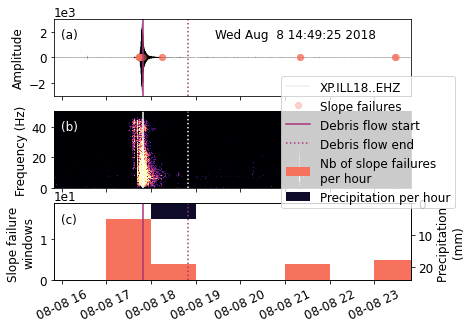

In [16]:
fig, (ax1,ax2,ax0) = plt.subplots(3,1,figsize=(6.4, 4.8), sharex=True)
#ax1.plot_date(ns_dat.index, ns_dat['261'], '-', color=colors[0], label='Air temperature')

# Plot raw data
ax1.plot_date(tr1.times('matplotlib'), tr1.data,'k-', linewidth=0.1, label=tr.id)

# Plot spectrogram
im = ax2.pcolormesh([tr.stats.starttime.datetime + timedelta(seconds=x) for x in t], f, 10*np.log10(Sxx), cmap=cmap, vmin=2,vmax=25,rasterized=True)

# Plot slope failures
ax1.plot(tslops, dslops, 'o', alpha=0.3, color=colors[2], label='Slope failures')

ax2.set_ylabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')

# Plot bar plot with slope failures per hour
ax0.bar(decs.index, decs['classes'], width=0.042, color=colors[2],  align='edge', label='Nb of slope failures \nper hour')
ax0.xaxis_date()
ax0.set_ylabel('Slope failure \nwindows')
ax0.tick_params(axis='x', rotation=25)
ymax = np.max(decs['classes'])+0.25*np.max(decs['classes'])
ax0.set_ylim(0,ymax)

# Plot bar plot with precipitation per hour
ax3 = ax0.twinx()
ax3.bar(nss.index, nss['267'], width=0.042 ,color=colors[0], label='Precipitation per hour', align='edge')
ax3.xaxis_date()
ax3.set_ylabel('Precipitation \n(mm)')
ax3.set_ylim(0,np.max(nss['267'])/(ymax-np.max(decs['classes']))*ymax) # adjust the second yscale to 100%
ax3.set_ylim(ax3.get_ylim()[::-1]) # slip y scale

# Plot debris-flow start and end
for ax in (ax3,ax1,ax2):
    if ax == ax1:
        ax.axvline(tds, color=colors[1], label= 'Debris flow start')
        ax.axvline(tde, color=colors[1], linestyle=':',label= 'Debris flow end')
    elif ax == ax2:
        ax.axvline(tds, color='white')
        ax.axvline(tde, color='white', linestyle=':')
    else:
        ax.axvline(tds, color=colors[1])
        ax.axvline(tde, color=colors[1], linestyle=':')

ax0.set_xlim(tds - timedelta(seconds=2*3600), tde + timedelta(seconds=5*3600))

#ax3.legend(loc="upper right")
#ax0.legend(loc='lower right')
fig.legend(bbox_to_anchor = [1, 0.75])
#ax2.legend(loc='lower right')
annot = ['(a)','(b)', '(c)']
axes = (ax1, ax2, ax0)
for ax, an in zip(axes,annot):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if an == '(b)':
        ax.text(xlim[0] + 0.02*(xlim[1] - xlim[0]), ylim[1] - 0.25*(ylim[1] - ylim[0]), an, color='white')
    elif an == '(a)':
        ax.text(xlim[0] + 0.02*(xlim[1] - xlim[0]), ylim[1] - 0.25*(ylim[1] - ylim[0]), an)
        ax.text(xlim[0] + 0.45*(xlim[1] - xlim[0]), ylim[1] - 0.25*(ylim[1] - ylim[0]), tr.stats.starttime.ctime())
    else:
        ax.text(xlim[0] + 0.02*(xlim[1] - xlim[0]), ylim[1] - 0.25*(ylim[1] - ylim[0]), an)
        
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax0.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#plt.savefig(f'../plot/{year}/0_eval_{tr.stats.starttime.date}_{plot_ending}.png',bbox_inches='tight', dpi=300)

In [10]:
# Get start and endtime
#tstart = obspy.UTCDateTime(f'{year}-06-21')
tstart = obspy.UTCDateTime(obspy.UTCDateTime(ts[evnb]).date)
tend = tstart + timedelta(days=1)

gr_mask = (df_group.index > tstart.datetime) & (df_group.index <= tend.datetime) # daily
ns_gr_mask = (ns_group.index > tstart.datetime) & (ns_group.index<= tend.datetime) #daily
df_gr_mask = df_group[gr_mask]
df_ns_gr_mask = ns_group[ns_gr_mask]

NameError: name 'evnb' is not defined

(24.0, 0.0)

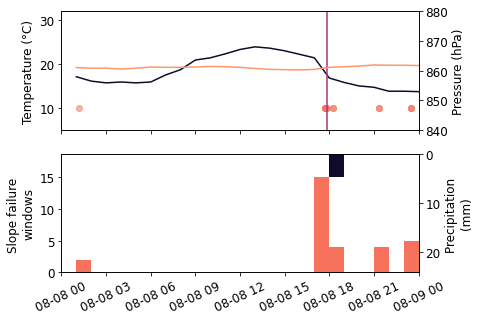

In [35]:
# Zoom in
fig, (ax1,ax0) = plt.subplots(2,1,figsize=(6.4, 4.8), sharex=True)

ax1.plot_date(df_ns_gr_mask.index, df_ns_gr_mask['261'], '-', color=colors[0], label='Air temperature at surface')
ax1.plot(dttimes, [x*10 for x in all_class], 'o', alpha=0.3, color=colors[2], label='Slope failures')

# Plot debris-flow events as vertical lines
for ts_i in ts:
    ax1.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color=colors[1])
ax1.set_ylim(5,32)

ax2 = ax1.twinx()
ax2.plot_date(df_ns_gr_mask.index, df_ns_gr_mask['306'], '-',color=colors[3], label='Atmospheric pressure')
ax1.set_ylabel('Temperature (°C)')
ax2.set_ylabel('Pressure (hPa)')

# Limit to zoom
#ax1.set_xlim(datetime.strptime('2019060000', "%Y%m%d%H%M"), datetime.strptime('201906230000', "%Y%m%d%H%M"))
ax1.set_xlim(tstart.datetime,tend.datetime)
ax1.tick_params(axis='x', rotation=25)
#ax1.legend(loc='upper right')
#ax2.legend(loc='lower right')
ax2.set_ylim(840,880)

#ax0.bar(df_gr_mask.index, df_gr_mask['classes'], width=0.042, color=colors[2])
#ax0.set_xlabel('Hour of the day')
#ax0.set_ylabel('Nb of slope failure \nwindows')
#ax0.set_ylim(0,np.max(df_gr_mask['classes']))
#ax0.tick_params(axis='x', rotation=25)

# Plot bar plot with slope failures per hour
ax0.bar(df_gr_mask.index, df_gr_mask['classes'], width=0.042, color=colors[2],  align='edge', label='Nb of slope failures \nper hour')
ax0.xaxis_date()
ax0.set_ylabel('Slope failure \nwindows')
ax0.tick_params(axis='x', rotation=25)
ymax = np.max(df_gr_mask['classes'])+0.25*np.max(decs['classes'])
ax0.set_ylim(0,ymax)

# Plot bar plot with precipitation per hour
ax3 = ax0.twinx()
ax3.bar(df_ns_gr_mask.index, df_ns_gr_mask['267'], width=0.042 ,color=colors[0], label='Precipitation per hour', align='edge')
ax3.xaxis_date()
ax3.set_ylabel('Precipitation \n(mm)')
ax3.set_ylim(0,np.max(df_ns_gr_mask['267'])/(ymax-np.max(df_gr_mask['classes']))*ymax) # adjust the second yscale to 100%
ax3.set_ylim(ax3.get_ylim()[::-1]) # slip y scale

#plt.legend(bbox_to_anchor = (1.04,1), loc="upper left")

#plt.savefig(f'../plot/{year}/{year}_zoom_h_{plot_ending}.png',bbox_inches='tight', dpi=300)

## Exclude number of events before/during debris flows

Input:
- class_res
- ns_dat
- ts
- te

In [4]:
class_mask, ns_dat_per, ns_dat_mask = mask_debrisflow(class_res, ns_dat, ts, te)
df_polar, df_polar_mask, ns_polar, ns_polar_mask = mask_polar(class_res, class_mask, ns_dat, ns_dat_per, ns_dat_mask)
group_all_DF, group_all, group_all5_DF, group_all5 = some_processing(class_res, class_mask, ns_dat_per, ns_dat_mask)

/media/manuela/UNTITLED/illgraben/code/ILL_functions.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ns_dat_mask.loc[ns_dat_per[ns_mask].index, '267'] = 0


Text(0.55, 0.55, '(c)')

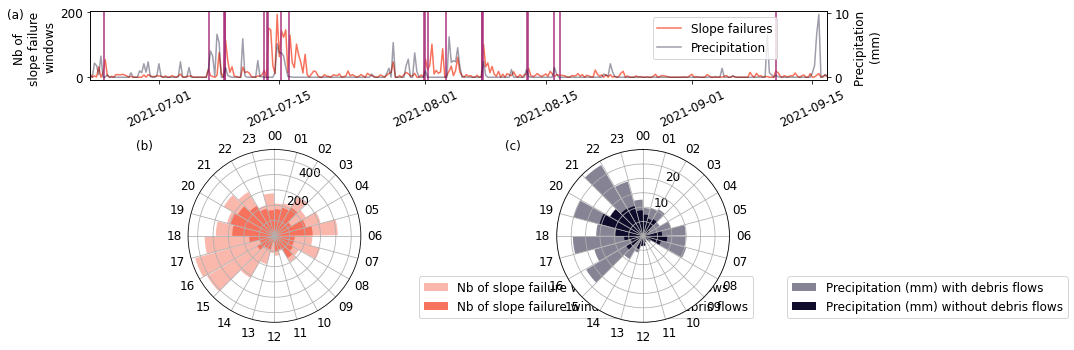

In [6]:
fig = plt.figure(figsize = (6.4*2, 4.8))
# [left bottom width height] 
ax2 = fig.add_axes([0.1, 0.75, 0.8, 0.2]) # WAVEFORM
ax0 = fig.add_axes([0.1, 0.05, 0.4, 0.5], projection='polar') # SPECTRUM
ax1 = fig.add_axes([0.5, 0.05, 0.4, 0.5], projection='polar') # COLORBAR

#fig = plt.figure(figsize=(16,6))
#ax2 = plt.subplot(131)
#ax1 = plt.subplot(132, projection='polar')
#ax0 = plt.subplot(133, projection='polar')

ax2.plot_date(group_all5.index, group_all5['classes'], marker=None, linestyle='-', color=colors[2], label='Slope failures')
ax3 = ax2.twinx()
ax3.plot_date(group_all5.index, group_all5['267'], marker=None, linestyle='-', color=colors[0], alpha=0.4, label='Precipitation')
# Plot debris-flow events as vertical lines
for ts_i in ts:
    ax2.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color=colors[1])
ax2.set_xlim(group_all5.index[0],group_all5.index[-1])
ax2.tick_params(axis='x', rotation=25)
ax2.set_ylabel('Nb of \nslope failure \nwindows')
ax3.set_ylabel('Precipitation \n(mm)')
fig.legend(bbox_to_anchor = [0.85, 0.98])

#ax0.projection('polar')
theta = np.linspace(0.0, 2 * np.pi, len(df_polar.index), endpoint=False)
ax0.bar(theta, df_polar['classes'], width=0.25, align='edge', color=colors[2], alpha=.5, label='Nb of slope failure windows with debris flows')
ax0.bar(theta, df_polar_mask['classes'], width=0.25, align='edge', color=colors[2], label='Nb of slope failure windows without debris flows')
ax1.bar(theta, ns_polar['267'], width=0.25, align='edge', color=colors[0], alpha=.5, label='Precipitation (mm) with debris flows')
ax1.bar(theta, ns_polar_mask['267'], width=0.25, align='edge', color=colors[0], label='Precipitation (mm) without debris flows')
#ax0.set_xlabel('Hour of the day')
#ax0.set_ylabel('Nb of slope failure \nwindows')
#ax0.set_xlim(-0.5,23.5)
for ax in (ax0,ax1):
    # Make the labels go clockwise
    ax.set_theta_direction(-1)
    #Place Zero at Top
    ax.set_theta_offset(np.pi/2)
    #Set the circumference ticks
    ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
    # set the label names
    ticks = ['00', '01', '02', '03', '04', '05', '06', '07','08','09','10','11','12', '13', '14', '15', '16',  '17', '18', '19', '20', '21', '22', '23' ]
    ax.set_xticklabels(ticks)
    # suppress the radial labels
    #plt.setp(ax0.get_yticklabels(), visible=False)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    ax.legend(bbox_to_anchor = [1.3, 0.3])
    plt.setp(ax.get_yticklabels()[-1], visible=False)
#plt.setp(ax0.get_yticklabels()[-2], visible=False)
fig.text(0.01,0.93, '(a)')    
fig.text(0.15,0.55, '(b)')
fig.text(0.55,0.55, '(c)')

#plt.savefig(f'../plot/{year}/ns_vs_sf_{plot_ending}_excludeDF.png',bbox_inches='tight', dpi=300)

### Include Moisture Measurements

In [7]:
# with Moisture
class_mask, ns_dat_per, ns_dat_mask = mask_debrisflow(class_res, ns_dat, ts, te)
df_mois_per,df_mois_mask = mask_moisture(class_res, ts, te)
df_polar, df_polar_mask, ns_polar, ns_polar_mask = mask_polar(class_res, class_mask, ns_dat, ns_dat_per, ns_dat_mask)
group_all_DF, group_all, group_all5_DF, group_all5 = some_processing_with_moisture(class_res, class_mask, ns_dat_per, ns_dat_mask, df_mois_per, df_mois_mask)

/media/manuela/UNTITLED/illgraben/code/ILL_functions.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ns_dat_mask.loc[ns_dat_per[ns_mask].index, '267'] = 0
/media/manuela/UNTITLED/illgraben/code/ILL_functions.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_mois_mask.loc[df_mois_per[mois_mask].index, df_mois.columns.values[1:8]] = 0


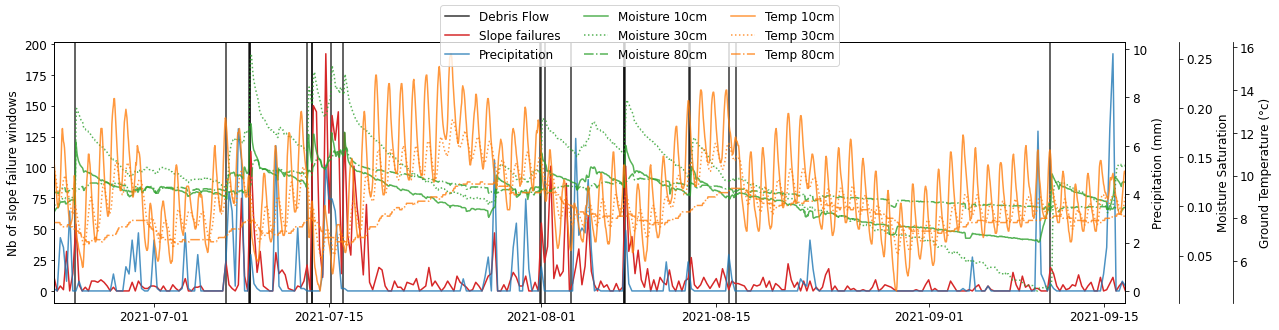

In [20]:
fig, ax2 = plt.subplots(figsize = (6.4*3, 4.8))
#ax2 = fig.add_axes() # [left bottom width height] 
# Plot debris-flow events as vertical lines
for ts_i in ts:
    ax2.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color='k', alpha=0.8)
ax2.axvline(color='k', alpha=0.8, label='Debris Flow')
ax2.plot_date(group_all5.index, group_all5['classes'], marker=None, linestyle='-', color='C3', label='Slope failures')
ax3 = ax2.twinx()
ax3.plot_date(group_all5.index, group_all5['267'], marker=None, linestyle='-', color='C0', alpha=0.8, label='Precipitation')
ax4 = ax2.twinx()
ax4.plot_date(df_mois_per.index, df_mois_per['SM10cm'], marker=None, linestyle='-', color='C2', alpha=0.8, label='Moisture 10cm')
ax4.plot_date(df_mois_per.index, df_mois_per['SM30cm'], marker=None, linestyle=':', color='C2', alpha=0.8, label='Moisture 30cm')
ax4.plot_date(df_mois_per.index, df_mois_per['SM80cm'], marker=None, linestyle='-.', color='C2', alpha=0.8, label='Moisture 80cm')
ax5 = ax2.twinx()
ax5.plot_date(df_mois_per.index, df_mois_per['T10cm'], marker=None, linestyle='-', color='C1', alpha=0.8, label='Temp 10cm')
ax5.plot_date(df_mois_per.index, df_mois_per['T30cm'], marker=None, linestyle=':', color='C1', alpha=0.8, label='Temp 30cm')
ax5.plot_date(df_mois_per.index, df_mois_per['T80cm'], marker=None, linestyle='-.', color='C1', alpha=0.8, label='Temp 80cm')

ax2.set_xlim(group_all5.index[0],group_all5.index[-1])
ax2.tick_params(axis='x', rotation=0)
ax2.set_ylabel('Nb of slope failure windows')
ax3.set_ylabel('Precipitation (mm)')
ax4.set_ylabel('Moisture Saturation')
ax4.spines['right'].set_position(('axes',1.05))
ax5.set_ylabel('Ground Temperature (°c)')
ax5.spines['right'].set_position(('axes',1.1))
fig.legend(ncol=3, loc='upper center')

#plt.savefig(f'../plot/{year}/ns_vs_sf_{plot_ending}_ground.png',bbox_inches='tight', dpi=300)

### Detection per Station

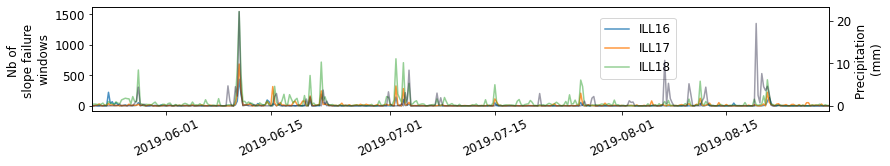

In [153]:
# ONLY TOP PLOT
fig = plt.figure(figsize = (6.4*2, 4.8))
# [left bottom width height] 
ax2 = fig.add_axes([0.1, 0.75, 0.8, 0.3]) # WAVEFORM
#ax1 = fig.add_axes([0.5, 0.05, 0.4, 0.5], projection='polar') # COLORBAR

ax2.plot_date(group_all5_ILL16.index, group_all5_ILL16['classes'], marker=None, linestyle='-', alpha=0.8, color='C0', label='ILL16')
ax2.plot_date(group_all5_ILL17.index, group_all5_ILL17['classes'], marker=None, linestyle='-', alpha=0.8, color='C1', label='ILL17')
ax2.plot_date(group_all5_ILL18.index, group_all5_ILL18['classes'], marker=None, linestyle='-', alpha=0.5, color='C2', label='ILL18')

ax3 = ax2.twinx()
ax3.plot_date(group_all5_ILL16.index, group_all5_ILL16['267'], marker=None, linestyle='-', color=colors[0], alpha=0.4, label='Precipitation')
ax2.tick_params(axis='x', rotation=25)
ax2.set_ylabel('Nb of \nslope failure \nwindows')
ax3.set_ylabel('Precipitation \n(mm)')
ax2.legend(bbox_to_anchor = [0.8, 0.95])
ax2.set_xlim(group_all5_ILL18.index[0],group_all5_ILL18.index[-1])

plt.savefig(f'../plot/ns_vs_sf_v4_ILL_b.png',bbox_inches='tight', dpi=300)

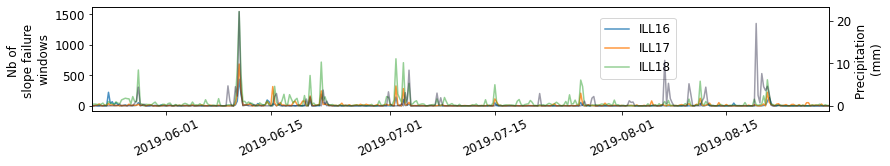

In [153]:
# ONLY TOP PLOT

year = 2017
files = ['ILL16', 'ILL17', 'ILL18']
plot_ending = 'v4_bigsf_clf2_ILLx8'
path_to_raw_data = '/media/manuela/Elements/illgraben/miniseed/'

fig = plt.figure(figsize = (6.4*2, 4.8))
# [left bottom width height] 
ax2 = fig.add_axes([0.1, 0.75, 0.8, 0.3]) # WAVEFORM

for i_color, file in enumerate(files):
    file_ending = f'v4_bigsf_clf2_{file}'
    class_res, dttimes, all_class, tslops, dslops = read_features(year, file_ending)
    df_group_d, df_group, ns_dat, ns_group_d, ns_group = read_meteo(class_res, year)
    
    class_mask, ns_dat_per, ns_dat_mask = mask_debrisflow(class_res, ns_dat, ts)
    df_polar, df_polar_mask, ns_polar, ns_polar_mask = mask_polar(class_res, class_mask, ns_dat, ns_dat_per, ns_dat_mask)
    group_all_DF, group_all, group_all5_DF, group_all5 = some_processing(class_res, class_mask, ns_dat_per, ns_dat_mask)
    ax2.plot_date(group_all5.index, group_all5['classes'], marker=None, linestyle='-', alpha=0.8, color=f'C{i_color}', label='ILL16')

ax3 = ax2.twinx()
ax3.plot_date(group_all5.index, group_all5['267'], marker=None, linestyle='-', color=colors[0], alpha=0.4, label='Precipitation')
ax2.tick_params(axis='x', rotation=25)
ax2.set_ylabel('Nb of \nslope failure \nwindows')
ax3.set_ylabel('Precipitation \n(mm)')
ax2.legend(bbox_to_anchor = [0.8, 0.95])
ax2.set_xlim(group_all5.index[0],group_all5.index[-1])

#plt.savefig(f'../plot/{plot_ending}.png',bbox_inches='tight', dpi=300)

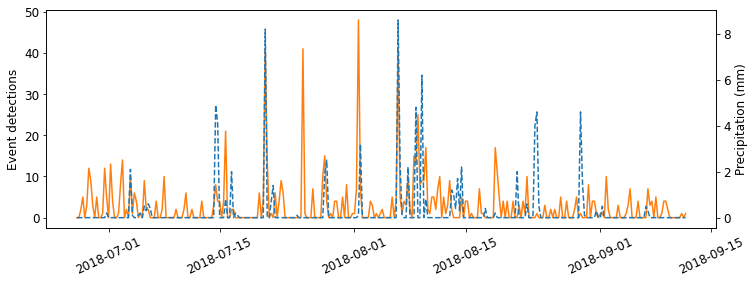

In [27]:
fig = plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.plot_date(group_all5.index, group_all5['classes'], 'C1')
ax.set_ylabel('Event detections')
ax1 = ax.twinx()
ax1.plot_date(group_all5.index, group_all5['267'], 'C0',linestyle='--')
ax1.set_ylabel('Precipitation (mm)')
ax.tick_params(axis='x', rotation=25)

### Timeserie over all Years

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana


FileNotFoundError: [Errno 2] No such file or directory: '../meteodata/2017.dat'

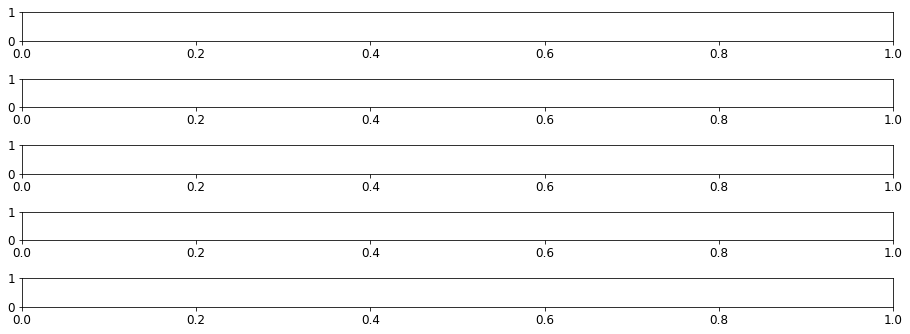

In [3]:
fig, (ax1,ax2, ax3, ax4, ax5) = plt.subplots(5,1,figsize=(6.4*2, 4.8))
fig.tight_layout()

years = [2017, 2018, 2019, 2020, 2021, 2022]
axs = [ax1,ax2, ax3, ax4, ax5]
file_ending = 'v4_bigsf_clf2_ILLx8_new'
plot_ending = 'v4_bigsf_clf2_ILLx8_new'
path_to_raw_data = '/data/wsd03/data_manuela/Illgraben/miniseed/'

time_list = []

for i, (ax, year) in enumerate(zip(axs, years)):
    class_res, dttimes, all_class, tslops, dslops = read_features(year, file_ending)
    df_group_d, df_group, ns_dat, ns_group_d, ns_group = read_meteo(class_res, year)
    
    ts,te = DF_detections(year) # DFs start and end times
    
    class_mask, ns_dat_per, ns_dat_mask = mask_debrisflow(class_res, ns_dat, ts, te)
    df_polar, df_polar_mask, ns_polar, ns_polar_mask = mask_polar(class_res, class_mask, ns_dat, ns_dat_per, ns_dat_mask)
    group_all_DF, group_all, group_all5_DF, group_all5 = some_processing(class_res, class_mask, ns_dat_per, ns_dat_mask)

    ax.plot(group_all5_DF['classes'], marker=None, linestyle='-', alpha=1, color='C3', label='Slope failures')
    ax0 = ax.twinx()
    ax0.plot(group_all5_DF['267'], marker=None, linestyle='-', color='C0', alpha=0.8, label='Precipitation')

    for ts_i in ts:
        ax.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color='k', alpha=0.5)
    
    stime = group_all5_DF.index[0]
    etime = group_all5_DF.index[-1]
    ax.set_xlim(stime,etime)
    time_list.append([stime, stime.strftime('%m-%d'), etime, etime.strftime('%m-%d')]) # start and end Month and Day to list

    h_int = 24*7
    mdates.DayLocator(bymonthday=(1))
    daterange = pd.date_range(stime, etime, freq=str(h_int)+'h', normalize=True)
    
    myFmt = mdates.DateFormatter('%-d %b') 
    months = mdates.MonthLocator()  
    days = mdates.DayLocator(bymonthday=(1))   
    dayss = mdates.DayLocator()
    
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(days)
    ax.xaxis.set_minor_locator(dayss)
    
#for ax in axs:
#    ax.set_xlim(df_time['s_UTC'].loc[df_time['s_date'] == min(df_time['s_date'])],
#                df_time['e_UTC'].loc[df_time['s_date'] == max(df_time['e_date'])])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(xlim[0] + 0.95*(xlim[1] - xlim[0]), ylim[1] - 0.36*(ylim[1] - ylim[0]), f'{year}')
    
fig.text(0.001, 0.5, 'Nb of slope failure windows per 6h', va='center', rotation='vertical')
fig.text(0.994, 0.5, 'Precipitation (mm/6h)', va='center', rotation='vertical')
fig.tight_layout() 
#plt.savefig(f'../plot/{plot_ending}.png',bbox_inches='tight', dpi=300)

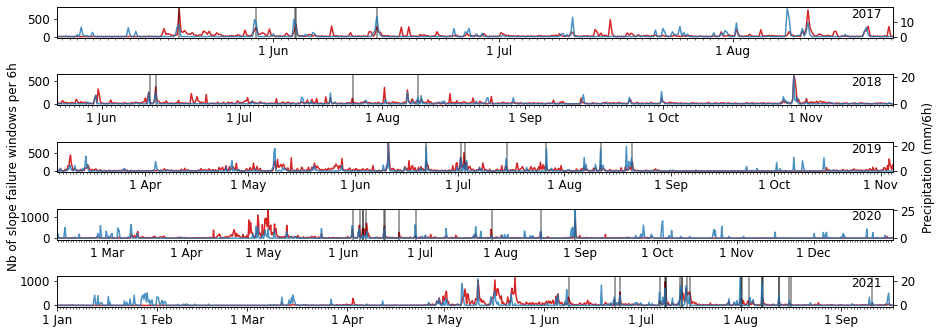

In [8]:
fig, (ax1,ax2, ax3, ax4, ax5) = plt.subplots(5,1,figsize=(6.4*2, 4.8))
fig.tight_layout()

years = [2017, 2018, 2019, 2020, 2021]
axs = [ax1,ax2, ax3, ax4, ax5]
file_ending = 'v4_bigsf_clf2_ILLx8_new'
plot_ending = 'v4_bigsf_clf2_ILLx8_new'
path_to_raw_data = '/data/wsd03/data_manuela/Illgraben/miniseed/'

time_list = []

for i, (ax, year) in enumerate(zip(axs, years)):
    class_res, dttimes, all_class, tslops, dslops = read_features(year, file_ending)
    df_group_d, df_group, ns_dat, ns_group_d, ns_group = read_meteo(class_res, year)
    
    ts,te = DF_detections(year) # DFs start and end times
    
    class_mask, ns_dat_per, ns_dat_mask = mask_debrisflow(class_res, ns_dat, ts, te)
    df_polar, df_polar_mask, ns_polar, ns_polar_mask = mask_polar(class_res, class_mask, ns_dat, ns_dat_per, ns_dat_mask)
    group_all_DF, group_all, group_all5_DF, group_all5 = some_processing(class_res, class_mask, ns_dat_per, ns_dat_mask)

    ax.plot(group_all5_DF['classes'], marker=None, linestyle='-', alpha=1, color='C3', label='Slope failures')
    ax0 = ax.twinx()
    ax0.plot(group_all5_DF['267'], marker=None, linestyle='-', color='C0', alpha=0.8, label='Precipitation')

    for ts_i in ts:
        ax.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color='k', alpha=0.5)
    
    stime = group_all5_DF.index[0]
    etime = group_all5_DF.index[-1]
    ax.set_xlim(stime,etime)
    time_list.append([stime, stime.strftime('%m-%d'), etime, etime.strftime('%m-%d')]) # start and end Month and Day to list

    h_int = 24*7
    mdates.DayLocator(bymonthday=(1))
    daterange = pd.date_range(stime, etime, freq=str(h_int)+'h', normalize=True)
    
    myFmt = mdates.DateFormatter('%-d %b') 
    months = mdates.MonthLocator()  
    days = mdates.DayLocator(bymonthday=(1))   
    dayss = mdates.DayLocator()
    
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(days)
    ax.xaxis.set_minor_locator(dayss)
    
#for ax in axs:
#    ax.set_xlim(df_time['s_UTC'].loc[df_time['s_date'] == min(df_time['s_date'])],
#                df_time['e_UTC'].loc[df_time['s_date'] == max(df_time['e_date'])])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(xlim[0] + 0.95*(xlim[1] - xlim[0]), ylim[1] - 0.36*(ylim[1] - ylim[0]), f'{year}')
    
fig.text(0.001, 0.5, 'Nb of slope failure windows per 6h', va='center', rotation='vertical')
fig.text(0.994, 0.5, 'Precipitation (mm/6h)', va='center', rotation='vertical')
fig.tight_layout() 
#plt.savefig(f'../plot/{plot_ending}.png',bbox_inches='tight', dpi=300)

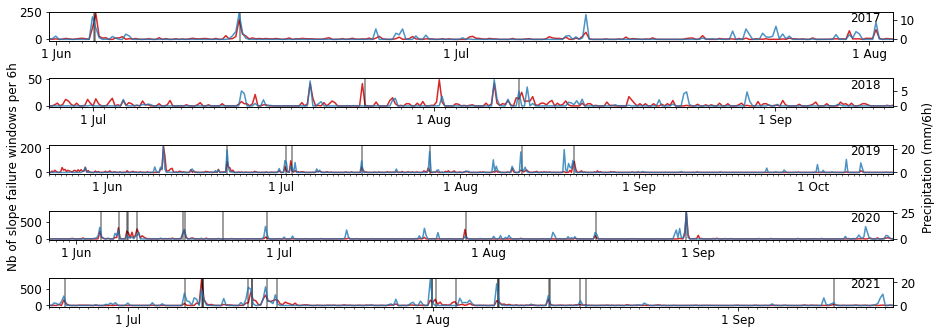

In [10]:
fig, (ax1,ax2, ax3, ax4, ax5) = plt.subplots(5,1,figsize=(6.4*2, 4.8))
fig.tight_layout()

years = [2017, 2018, 2019, 2020, 2021]
axs = [ax1,ax2, ax3, ax4, ax5]
file_ending = 'test_v4_bigsf_clf2'
plot_ending = 'v4_bigsf_clf2'
path_to_raw_data = '/media/manuela/Elements/illgraben/miniseed/'

time_list = []

for i, (ax, year) in enumerate(zip(axs, years)):
    class_res, dttimes, all_class, tslops, dslops = read_features(year, file_ending)
    df_group_d, df_group, ns_dat, ns_group_d, ns_group = read_meteo(class_res, year)
    
    ts,te = DF_detections(year) # DFs start and end times
    
    class_mask, ns_dat_per, ns_dat_mask = mask_debrisflow(class_res, ns_dat, ts, te)
    df_polar, df_polar_mask, ns_polar, ns_polar_mask = mask_polar(class_res, class_mask, ns_dat, ns_dat_per, ns_dat_mask)
    group_all_DF, group_all, group_all5_DF, group_all5 = some_processing(class_res, class_mask, ns_dat_per, ns_dat_mask)

    ax.plot(group_all5_DF['classes'], marker=None, linestyle='-', alpha=1, color='C3', label='Slope failures')
    ax0 = ax.twinx()
    ax0.plot(group_all5_DF['267'], marker=None, linestyle='-', color='C0', alpha=0.8, label='Precipitation')

    for ts_i in ts:
        ax.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color='k', alpha=0.5)
    
    stime = group_all5_DF.index[0]
    etime = group_all5_DF.index[-1]
    ax.set_xlim(stime,etime)
    time_list.append([stime, stime.strftime('%m-%d'), etime, etime.strftime('%m-%d')]) # start and end Month and Day to list

    h_int = 24*7
    mdates.DayLocator(bymonthday=(1))
    daterange = pd.date_range(stime, etime, freq=str(h_int)+'h', normalize=True)
    
    myFmt = mdates.DateFormatter('%-d %b') 
    months = mdates.MonthLocator()  
    days = mdates.DayLocator(bymonthday=(1))   
    dayss = mdates.DayLocator()
    
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(days)
    ax.xaxis.set_minor_locator(dayss)
    
#for ax in axs:
#    ax.set_xlim(df_time['s_UTC'].loc[df_time['s_date'] == min(df_time['s_date'])],
#                df_time['e_UTC'].loc[df_time['s_date'] == max(df_time['e_date'])])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(xlim[0] + 0.95*(xlim[1] - xlim[0]), ylim[1] - 0.36*(ylim[1] - ylim[0]), f'{year}')
    
fig.text(0.001, 0.5, 'Nb of slope failure windows per 6h', va='center', rotation='vertical')
fig.text(0.994, 0.5, 'Precipitation (mm/6h)', va='center', rotation='vertical')
fig.tight_layout() 
#plt.savefig(f'../plot/{plot_ending}.png',bbox_inches='tight', dpi=300)

In [28]:
group_all_DF.loc[group_all_DF['267']==max(group_all_DF['267'])]

,classes,266,261,267,274,269,283,306,580,datetime
Date,,,,,,,,,,
2021-06-08 12:00:00,0,88.0,11.8,32767.0,0,106,1.7,862.9,32767,2021-06-08 12:00:00
2021-06-08 13:00:00,42,78.6,13.2,32767.0,1,408,1.6,862.5,32767,2021-06-08 13:00:00
2021-06-08 14:00:00,21,69.5,14.4,32767.0,47,826,2.4,862.5,32767,2021-06-08 14:00:00
2021-06-08 15:00:00,105,72.5,15.5,32767.0,29,719,2.8,862.4,32767,2021-06-08 15:00:00
2021-06-08 16:00:00,114,79.0,14.0,32767.0,0,285,3.3,862.3,32767,2021-06-08 16:00:00
2021-06-08 17:00:00,60,82.0,13.2,32767.0,0,170,1.1,862.4,32767,2021-06-08 17:00:00
2021-06-08 18:00:00,18,90.5,12.7,32767.0,0,70,1.1,862.7,32767,2021-06-08 18:00:00
2021-06-08 19:00:00,63,90.8,12.1,32767.0,0,15,1.4,863.0,32767,2021-06-08 19:00:00
2021-06-08 20:00:00,60,91.9,11.2,32767.0,0,3,1.2,863.0,32767,2021-06-08 20:00:00


In [172]:
df_time = pd.DataFrame(time_list, columns=['s_UTC', 's_date', 'e_UTC', 'e_date'])
min(df_time['s_date'])
max(df_time['e_date'])

'10-14'

In [201]:
df_time['s_UTC'].loc[df_time['s_date'] == min(df_time['s_date'])]

2   2019-05-22
Name: s_UTC, dtype: datetime64[ns]

In [ ]:
stime = group_all5.index[0]
etime = group_all5.index[-1]
ax.set_xlim(stime,etime)

h_int = 24*3
# x_ticks_hours = np.arange(np.min(t),(np.max(t)-np.min(t))/3600,h_int)
# starttime = df_plot.index[df_plot['time']==0.]
# x_ticks_timestamps = [starttime[0] + pd.Timedelta(dt,'H') for dt in x_ticks_hours]
daterange = pd.date_range(stime, etime, freq=str(h_int)+'h', normalize=True)
# x_ticks_str = [t.strftime('%-d %b %-Hh') for t in x_ticks_timestamps]
x_ticks_str = [t.strftime('%-d %b') for t in daterange]
x_tickloc = daterange
ax.set_xticks(x_tickloc)
ax.set_xticklabels(x_ticks_str)

In [93]:
group_all5.index.strftime('%b').unique()

Index(['Jun', 'Jul', 'Aug', 'Sep'], dtype='object', name='datetime')

In [48]:
group_all5

,classes,266,261,267,274,269,283,306,580
datetime,,,,,,,,,
2018-06-27 00:00:00,0,374.5,47.7,0.0,0,23,6.1,4309.6,163835
2018-06-27 06:00:00,0,370.0,89.4,0.0,355,3973,9.2,5166.5,196602
2018-06-27 12:00:00,2,225.2,123.6,0.0,360,4851,26.6,5153.4,196602
2018-06-27 18:00:00,5,282.1,86.2,0.0,47,182,16.6,5154.8,196602
2018-06-28 00:00:00,0,397.5,54.0,0.0,0,26,8.0,5149.9,163835
...,...,...,...,...,...,...,...,...,...
2018-09-10 18:00:00,0,297.7,94.0,0.0,4,40,7.1,5207.2,196602
2018-09-11 00:00:00,0,367.6,69.1,0.0,0,6,9.0,5213.0,163835
2018-09-11 06:00:00,1,297.8,98.4,0.0,302,2721,7.5,5217.9,196602


In [42]:
all5_test = group_all5.copy()
all5_test['time'] = all5_test.inex.time

#pd.MultiIndex.from_list

In [49]:
group_all5.index.strftime('%m-%d %H')

Index(['06-27 00', '06-27 06', '06-27 12', '06-27 18', '06-28 00', '06-28 06',
       '06-28 12', '06-28 18', '06-29 00', '06-29 06',
       ...
       '09-09 12', '09-09 18', '09-10 00', '09-10 06', '09-10 12', '09-10 18',
       '09-11 00', '09-11 06', '09-11 12', '09-11 18'],
      dtype='object', name='datetime', length=308)

## Relation between detections and percipitation as time evolution

Input:
- df_group
- ns_group
- ts
- cmap

In [23]:
# read df
year = 2019
file_ending = 'test_v4_bigsf_clf2'
plot_ending = 'v4_bigsf_clf2'
path_to_raw_data = '/media/manuela/Elements/illgraben/miniseed/'

class_res, dttimes, all_class, tslops, dslops = read_features(year, file_ending)
df_group_d, df_group, ns_dat, ns_group_d, ns_group = read_meteo(class_res, year)

ts,te = DF_detections(year)

In [24]:
# mask hourly df with meteo data to same length as df_group with detections
ns_mask_hour = (ns_group.index >= df_group.index[0]) & (ns_group.index <= df_group.index[-1])
ns_group_hour = ns_group[ns_mask_hour].copy()
ns_group_hour.head()

,266,261,267,274,269,283,306,580
datetime,,,,,,,,
2019-05-22 00:00:00,78.5,6.6,0.0,0,1,1.3,858.0,0
2019-05-22 01:00:00,82.0,6.3,0.0,0,1,1.1,857.9,32767
2019-05-22 02:00:00,84.5,6.0,0.0,0,1,0.9,858.0,32767
2019-05-22 03:00:00,88.1,5.2,0.0,0,1,0.6,858.0,32767
2019-05-22 04:00:00,91.5,4.3,0.0,0,3,0.6,858.0,32767


In [25]:
# detections and meteo data to hourly dataframe
df_hour = pd.concat([df_group,ns_group_hour], axis=1) # df includes detections and meteo parameter (hourly)
df_hour_mask = df_hour.copy()

# mask debris flow
for i in range(len(ts)):
    tds = obspy.UTCDateTime(ts[i]).datetime
    tde = obspy.UTCDateTime(te[i]).datetime
    mask = (df_hour.index > tds - timedelta(seconds=3*3600)) & (df_hour.index <= tde+ timedelta(seconds=1*3600))
    df_hour_mask.loc[df_hour_mask[mask].index] = 0 # df with masked DF

# group every 6 hours for clearer picture
df_group6 = df_hour.copy().resample('6H').sum() # df resampled to 6H

df_group6_mask = df_hour_mask.copy().resample('6H').sum()
df_group6_mask # df with masked DF and resampled to 6H

,classes,266,261,267,274,269,283,306,580
datetimes,,,,,,,,,
2019-05-22 00:00:00,0,515.7,32.5,0.0,3,31,4.9,5148.1,163835
2019-05-22 06:00:00,0,472.1,50.9,0.0,227,2964,7.0,5152.3,196602
2019-05-22 12:00:00,11,276.8,79.4,0.0,203,3055,17.9,5150.7,196602
2019-05-22 18:00:00,5,351.0,57.2,0.0,30,175,13.1,5155.6,196602
2019-05-23 00:00:00,18,479.7,29.9,0.0,5,31,7.8,5156.7,163835
...,...,...,...,...,...,...,...,...,...
2019-10-13 18:00:00,1,286.4,87.1,0.0,0,12,22.3,5170.0,196602
2019-10-14 00:00:00,0,334.1,70.2,0.0,0,14,13.1,5167.6,163835
2019-10-14 06:00:00,0,303.9,82.1,0.0,264,1954,13.5,5162.8,196602


In [26]:
i_plot_ending = ['', '_withoutDF', '_6h', '_6h_withoutDF']
i_axlabel = ['', '', '6', '6']
df_list = [df_hour, df_hour_mask, df_group6, df_group6_mask]

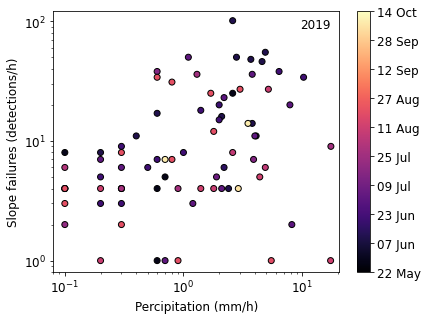

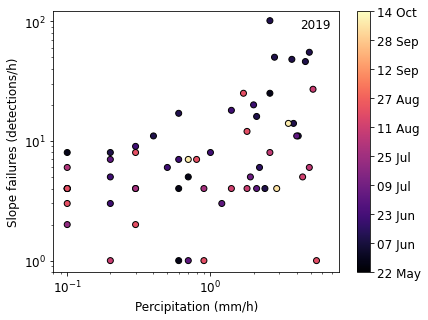

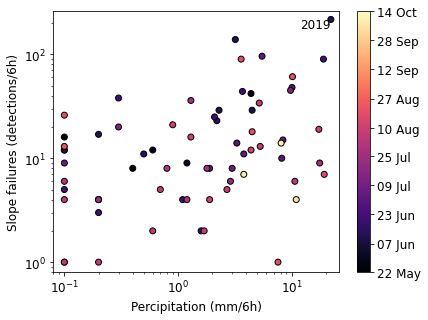

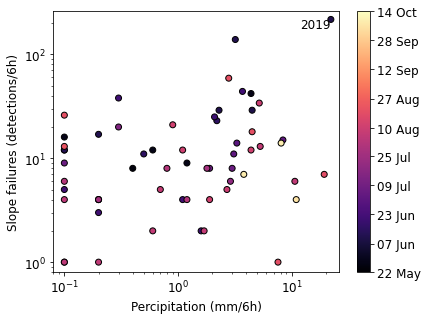

In [27]:
for i_plt_ending, i_ax, df in zip(i_plot_ending, i_axlabel, df_list):
    N_TICKS = 10
    fig, ax = plt.subplots()
    smap = ax.scatter(df['267'],df['classes'],c=df.index, alpha=1,
                      edgecolors='k', marker='o', cmap=cmap)
    plt.xlabel(f'Percipitation (mm/{i_ax}h)')
    plt.ylabel(f'Slope failures (detections/{i_ax}h)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlim(0.08,max(df['267'])+int(max(df['267'])/5))
    plt.ylim(0.8,max(df['classes'])+int(max(df['classes'])/5))
    indexes = [df.index[i] for i in np.linspace(0,df.shape[0]-1,N_TICKS).astype(int)] 

    cb = fig.colorbar(smap, orientation='vertical',
                      ticks= df.loc[indexes].index.astype(int))

    cb.ax.set_yticklabels([index.strftime('%d %b') for index in indexes])

    fig.text(0.66,0.83, f'{year}')
    plt.savefig(f'../plot/{year}/evolution_log{i_plt_ending}_{plot_ending}.png',bbox_inches='tight', dpi=300)